In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import pickle
import os
from datetime import datetime
import joblib

# For preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve
from imblearn.under_sampling import RandomUnderSampler

# Models to test
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# For visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Create results directory if it doesn't exist
os.makedirs('model_results', exist_ok=True)

# Set random seed for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Configuration
MODEL_SAVE_PATH = "model_results/models/"
RESULTS_PATH = "model_results/performance/"
os.makedirs(MODEL_SAVE_PATH, exist_ok=True)
os.makedirs(RESULTS_PATH, exist_ok=True)


[2025-05-06 10:48:56] Loading datasets...
[2025-05-06 10:49:03] Full features shape: (172158, 320)
[2025-05-06 10:49:03] PCA features shape: (172158, 22)


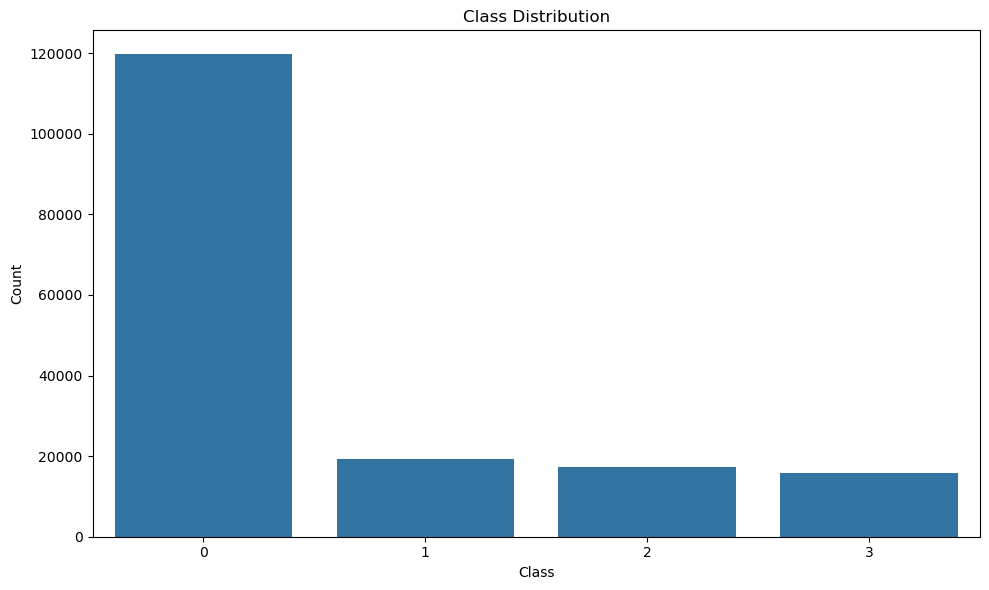

[2025-05-06 10:49:04] Basic statistics for full features:
         mfcc_mean_1    mfcc_mean_2    mfcc_mean_3    mfcc_mean_4  \
count  172158.000000  172158.000000  172158.000000  172158.000000   
mean     -202.147805     104.242202      -3.449694      33.099285   
std        46.690958      29.038250      22.363235      18.199227   
min      -587.890900     -48.756050    -120.591030     -64.199710   
25%      -228.983538      85.804102     -18.085362      21.611222   
50%      -198.576830     104.849713      -3.175696      33.621590   
75%      -171.370160     123.397373      11.444759      45.116199   
max        23.702822     225.372380      98.283066     123.808420   

         mfcc_mean_5    mfcc_mean_6    mfcc_mean_7    mfcc_mean_8  \
count  172158.000000  172158.000000  172158.000000  172158.000000   
mean      -10.704879      -0.207876     -17.218293      -4.900869   
std        16.253857      13.537224      12.514454      11.528187   
min       -82.523610     -71.355380     -94.

In [4]:
# Timestamp for unique filenames
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

# Logging function
def log_message(message):
    print(f"[{datetime.now().strftime('%Y-%m-%d %H:%M:%S')}] {message}")

## 1. Data Loading and Exploration

log_message("Loading datasets...")

# Load the full features dataset
full_features_df = pd.read_csv("data/features.csv")
# Load the PCA features dataset
pca_features_df = pd.read_csv("data/features_pca.csv")

log_message(f"Full features shape: {full_features_df.shape}")
log_message(f"PCA features shape: {pca_features_df.shape}")

# Check class distribution
plt.figure(figsize=(10, 6))
sns.countplot(x='label', data=full_features_df)
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.tight_layout()
plt.savefig(f"{RESULTS_PATH}class_distribution_{timestamp}.png")
plt.show()

# Display some basic statistics
log_message("Basic statistics for full features:")
print(full_features_df.describe())

# Check for missing values
missing_values_full = full_features_df.isnull().sum()
missing_values_pca = pca_features_df.isnull().sum()

log_message(f"Missing values in full features: {missing_values_full.sum()}")
log_message(f"Missing values in PCA features: {missing_values_pca.sum()}")


#under-sampling
def under_sample(X, y):
    rus = RandomUnderSampler(random_state=RANDOM_STATE)
    X_resampled, y_resampled = rus.fit_resample(X, y)
    return X_resampled, y_resampled


# Function to split data into train and test sets
def split_data(X, y, test_size=0.2, random_state=RANDOM_STATE):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state, stratify=y)
    return X_train, X_test, y_train, y_test

# Function to scale features
def scale_features(X_train, X_test):
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    return X_train_scaled, X_test_scaled, scaler

#perform undersampling and scaling
def preprocess_data(X, y, test_size=0.2, random_state=RANDOM_STATE):
    # Under-sample the data
    X_resampled, y_resampled = under_sample(X, y)
    
    # Split the data into train and test sets
    X_train, X_test, y_train, y_test = split_data(X_resampled, y_resampled, test_size=test_size, random_state=random_state)
    
    # Scale the features
    X_train_scaled, X_test_scaled, scaler = scale_features(X_train, X_test)
    
    return X_train_scaled, X_test_scaled, y_train, y_test, scaler


def preprocess_data_three_way_split(X, y, random_state=RANDOM_STATE):
    # Step 0: Under-sample the full dataset
    X_resampled, y_resampled = under_sample(X, y)

    # Step 1: Split into 90% train_val and 10% final test
    X_train_val, X_final_test, y_train_val, y_final_test = train_test_split(
        X_resampled, y_resampled, test_size=0.1, random_state=random_state, stratify=y_resampled
    )
    
    # Step 2: Split train_val into 70% training and 20% validation
    X_train, X_val, y_train, y_val = train_test_split(
        X_train_val, y_train_val, test_size=2/9, random_state=random_state, stratify=y_train_val
    )

    # Step 3: Scale using training statistics
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_final_test)

    return (
        X_train_scaled, X_val_scaled, X_test_scaled,
        y_train, y_val, y_final_test,
        scaler
    )


X_full = full_features_df.drop(columns=['label','filename'])
y_full = full_features_df['label']

X = pca_features_df.drop(columns=['label','filename'])
y = pca_features_df['label']

X_train, X_val, X_test, y_train, y_val, y_test, scaler = preprocess_data_three_way_split(X, y)

#check the shape of the data
print(f"Training data shape: {X_train.shape}, Labels shape: {y_train.shape}")
print(f"Validation data shape: {X_val.shape}, Labels shape: {y_val.shape}")
print(f"Test data shape: {X_test.shape}, Labels shape: {y_test.shape}")




In [6]:
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

def train_and_save_model(model, model_name, X_train, y_train, X_val, y_val, cv_folds=5):
    log_message(f"Running {cv_folds}-fold cross-validation for {model_name}...")
    scores = cross_val_score(model, X_train, y_train, cv=cv_folds, scoring='f1_macro', n_jobs=-1)
    log_message(f"{model_name} CV F1 macro scores: {scores}")
    log_message(f"{model_name} CV F1 macro mean: {scores.mean():.4f}, std: {scores.std():.4f}")

    # Optionally: See predictions during CV (on training set)
    # y_train_pred = cross_val_predict(model, X_train, y_train, cv=cv_folds, n_jobs=-1)
    # print("Training classification report from CV predictions:")
    # print(classification_report(y_train, y_train_pred))

    log_message(f"Training {model_name} on full training data...")
    model.fit(X_train, y_train)

    log_message(f"Evaluating {model_name} on validation set...")
    y_val_pred = model.predict(X_val)
    print("Validation Classification Report:")
    print(classification_report(y_val, y_val_pred))
    print("Confusion Matrix:")
    print(confusion_matrix(y_val, y_val_pred))
    print(f"Validation Accuracy: {accuracy_score(y_val, y_val_pred):.4f}")

    model_path = f"{RESULTS_PATH}{model_name}_{timestamp}.joblib"
    joblib.dump(model, model_path)
    log_message(f"{model_name} saved to {model_path}")


In [ ]:
rf_model = RandomForestClassifier(
    n_estimators=300,
    max_depth=20,
    min_samples_split=5,
    min_samples_leaf=2,
    class_weight='balanced',
    random_state=RANDOM_STATE,
    n_jobs=-1
)
train_and_save_model(rf_model, "RandomForest", X_train, y_train, X_val, y_val)

In [ ]:
xgb_model = XGBClassifier(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    use_label_encoder=False,
    eval_metric='mlogloss',
    random_state=RANDOM_STATE,
    n_jobs=-1
)
train_and_save_model(xgb_model, "XGBoost", X_train, y_train, X_val, y_val)

In [ ]:
lgb_model = LGBMClassifier(
    n_estimators=300,
    max_depth=10,
    learning_rate=0.05,
    num_leaves=64,
    subsample=0.8,
    colsample_bytree=0.8,
    class_weight='balanced',
    random_state=RANDOM_STATE,
    n_jobs=-1
)
train_and_save_model(lgb_model, "LightGBM", X_train, y_train, X_val, y_val)

In [ ]:
svm_model = SVC(
    kernel='rbf',
    C=10,
    gamma='scale',
    class_weight='balanced',
    probability=True,
    random_state=RANDOM_STATE
)
train_and_save_model(svm_model, "SVM", X_train, y_train, X_val, y_val)

In [ ]:
lr_model = LogisticRegression(
    C=1.0,
    solver='lbfgs',
    max_iter=1000,
    class_weight='balanced',
    multi_class='multinomial',
    random_state=RANDOM_STATE
)
train_and_save_model(lr_model, "LogisticRegression", X_train, y_train, X_val, y_val)

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

knn_model = KNeighborsClassifier(
    n_neighbors=5,
    weights='distance',
    n_jobs=-1
)
train_and_save_model(knn_model, "KNN", X_train, y_train, X_val, y_val)


In [ ]:
from sklearn.ensemble import VotingClassifier

voting_model = VotingClassifier(
    estimators=[
        ("rf", RandomForestClassifier(n_estimators=300, max_depth=20, min_samples_split=5, min_samples_leaf=2, class_weight='balanced', random_state=RANDOM_STATE, n_jobs=-1)),
        ("xgb", XGBClassifier(n_estimators=300, max_depth=6, learning_rate=0.05, subsample=0.8, colsample_bytree=0.8, use_label_encoder=False, eval_metric='mlogloss', random_state=RANDOM_STATE, n_jobs=-1)),
        ("lgb", LGBMClassifier(n_estimators=300, max_depth=10, learning_rate=0.05, num_leaves=64, subsample=0.8, colsample_bytree=0.8, class_weight='balanced', random_state=RANDOM_STATE, n_jobs=-1)),
        ("lr", LogisticRegression(C=1.0, solver='lbfgs', max_iter=1000, class_weight='balanced', multi_class='multinomial', random_state=RANDOM_STATE))
    ],
    voting='soft',
    n_jobs=-1
)

train_and_save_model(voting_model, "VotingEnsemble", X_train, y_train, X_val, y_val)

In [ ]:
from sklearn.ensemble import StackingClassifier

stacking_model = StackingClassifier(
    estimators=[
        ("rf", RandomForestClassifier(n_estimators=300, max_depth=20, min_samples_split=5, min_samples_leaf=2, class_weight='balanced', random_state=RANDOM_STATE, n_jobs=-1)),
        ("xgb", XGBClassifier(n_estimators=300, max_depth=6, learning_rate=0.05, subsample=0.8, colsample_bytree=0.8, use_label_encoder=False, eval_metric='mlogloss', random_state=RANDOM_STATE, n_jobs=-1)),
        ("lgb", LGBMClassifier(n_estimators=300, max_depth=10, learning_rate=0.05, num_leaves=64, subsample=0.8, colsample_bytree=0.8, class_weight='balanced', random_state=RANDOM_STATE, n_jobs=-1))
    ],
    final_estimator=LogisticRegression(C=1.0, max_iter=1000, class_weight='balanced', random_state=RANDOM_STATE),
    cv=5,
    n_jobs=-1
)

train_and_save_model(stacking_model, "StackingEnsemble", X_train, y_train, X_val, y_val)


In [7]:
#RERUN OF THE SAME EXPERIMENTS WITH K FEATURES
from sklearn.feature_selection import SelectKBest, f_classif

selector = SelectKBest(score_func=f_classif, k=100)  # tune `k`
X_selected = selector.fit_transform(X_full, y_full)
X_train, X_val, X_test, y_train, y_val, y_test, scaler = preprocess_data_three_way_split(X_selected, y)
print(f"Selected features shape: {X_selected.shape[1]}")



Selected features shape: 100


In [ ]:
voting_model = VotingClassifier(
    estimators=[
        ("rf", RandomForestClassifier(n_estimators=300, max_depth=20, min_samples_split=5, min_samples_leaf=2, class_weight='balanced', random_state=RANDOM_STATE, n_jobs=-1)),
        ("xgb", XGBClassifier(n_estimators=300, max_depth=6, learning_rate=0.05, subsample=0.8, colsample_bytree=0.8, use_label_encoder=False, eval_metric='mlogloss', random_state=RANDOM_STATE, n_jobs=-1)),
        ("lgb", LGBMClassifier(n_estimators=300, max_depth=10, learning_rate=0.05, num_leaves=64, subsample=0.8, colsample_bytree=0.8, class_weight='balanced', random_state=RANDOM_STATE, n_jobs=-1)),
        ("lr", LogisticRegression(C=1.0, solver='lbfgs', max_iter=1000, class_weight='balanced', multi_class='multinomial', random_state=RANDOM_STATE))
    ],
    voting='soft',
    n_jobs=-1
)

train_and_save_model(voting_model, "VotingEnsemble", X_train, y_train, X_val, y_val)

In [ ]:

from sklearn.ensemble import StackingClassifier
from sklearn.preprocessing import StandardScalers




stacking_model = StackingClassifier(
    estimators=[
        ("rf", RandomForestClassifier(n_estimators=300, max_depth=20, min_samples_split=5, min_samples_leaf=2, class_weight='balanced', random_state=RANDOM_STATE, n_jobs=-1)),
        ("xgb", XGBClassifier(n_estimators=300, max_depth=6, learning_rate=0.05, subsample=0.8, colsample_bytree=0.8, use_label_encoder=False, eval_metric='mlogloss', random_state=RANDOM_STATE, n_jobs=-1)),
        ("lgb", LGBMClassifier(n_estimators=300, max_depth=10, learning_rate=0.05, num_leaves=64, subsample=0.8, colsample_bytree=0.8, class_weight='balanced', random_state=RANDOM_STATE, n_jobs=-1))
    ],
    final_estimator=LogisticRegression(C=1.0, max_iter=1000, class_weight='balanced', random_state=RANDOM_STATE),
    cv=5,
    n_jobs=-1
)

train_and_save_model(stacking_model, "StackingEnsemble", X_train, y_train, X_val, y_val)

In [18]:
#testing stacking ensemble on the test set
log_message("Testing Stacking Ensemble on the test set...")
#load model C:\Users\Lenovo\Desktop\LastDitch\model_results\performance\StackingEnsemble_20250506_085046.joblib
#C:\Users\Lenovo\Desktop\LastDitch\model_results\performance\StackingEnsemble_20250506_091757.joblib
stacking_model = joblib.load(f"{RESULTS_PATH}StackingEnsemble_20250506_091757.joblib")
y_test_pred = stacking_model.predict(X_test)
# Print classification report and confusion matrix
print("Test Classification Report:")
print(classification_report(y_test, y_test_pred))
print("Test Confusion Matrix:")
print(confusion_matrix(y_test, y_test_pred))
print(f"Test Accuracy: {accuracy_score(y_test, y_test_pred):.4f}")
# Save the test predictions


[2025-05-06 11:02:23] Testing Stacking Ensemble on the test set...
Test Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.79      0.78      1583
           1       0.85      0.86      0.85      1582
           2       0.82      0.83      0.82      1583
           3       0.85      0.83      0.84      1582

    accuracy                           0.83      6330
   macro avg       0.83      0.83      0.83      6330
weighted avg       0.83      0.83      0.83      6330

Test Confusion Matrix:
[[1246   41  249   47]
 [  53 1356   11  162]
 [ 235   16 1311   21]
 [  63  181   26 1312]]
Test Accuracy: 0.8254


In [42]:
from sklearn.model_selection import StratifiedKFold
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier, StackingClassifier

meta_learner = XGBClassifier(
    n_estimators=100,
    max_depth=3,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    use_label_encoder=False,
    eval_metric='mlogloss',
    random_state=RANDOM_STATE,
    n_jobs=-1
)

stack_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

stacking_model_optimized = StackingClassifier(
    estimators=[
        ("rf", RandomForestClassifier(n_estimators=300, max_depth=20, min_samples_split=5, min_samples_leaf=2, class_weight='balanced', random_state=RANDOM_STATE, n_jobs=-1)),
        ("xgb", XGBClassifier(n_estimators=300, max_depth=6, learning_rate=0.05, subsample=0.8, colsample_bytree=0.8, use_label_encoder=False, eval_metric='mlogloss', random_state=RANDOM_STATE, n_jobs=-1)),
        ("lgb", LGBMClassifier(n_estimators=300, max_depth=10, learning_rate=0.05, num_leaves=64, subsample=0.8, colsample_bytree=0.8, class_weight='balanced', random_state=RANDOM_STATE, n_jobs=-1)),
        ("lr", LogisticRegression(C=1.0, max_iter=1000, class_weight='balanced', multi_class='multinomial', random_state=RANDOM_STATE)),
        ("nb", GaussianNB())
    ],
    final_estimator=meta_learner,
    cv=stack_cv,
    n_jobs=-1
)

train_and_save_model(stacking_model_optimized, "StackingEnsemble_Optimized", X_train, y_train, X_val, y_val)


[2025-05-06 10:18:25] Running 5-fold cross-validation for StackingEnsemble_Optimized...
[2025-05-06 10:27:03] StackingEnsemble_Optimized CV F1 macro scores: [0.6583963  0.6499247  0.64999072 0.64291199 0.65065763]
[2025-05-06 10:27:03] StackingEnsemble_Optimized CV F1 macro mean: 0.6504, std: 0.0049
[2025-05-06 10:27:03] Training StackingEnsemble_Optimized on full training data...


c:\Users\Lenovo\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [10:28:27] WARNING: C:\b\abs_90_bwj_86a\croot\xgboost-split_1724073762025\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[2025-05-06 10:28:27] Evaluating StackingEnsemble_Optimized on validation set...
Validation Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.61      0.61      3165
           1       0.66      0.75      0.70      3165
           2       0.65      0.65      0.65      3165
           3       0.70      0.62      0.66      3165

    accuracy                           0.66     12660
   macro avg       0.66      0.66      0.66     12660
weighted avg       0.66      0.66      0.66     12660

Confusion Matrix:
[[1936  205  815  209]
 [ 228 2373  130  434]
 [ 793  136 2051  185]
 [ 174  860  158 1973]]
Validation Accuracy: 0.6582
[2025-05-06 10:28:28] StackingEnsemble_Optimized saved to model_results/performance/StackingEnsemble_Optimized_20250506_101604.joblib
